## What's Cooking? Kaggle comp and CDA final project 

#### Description
Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

Acknowledgements: 
We want to thank Yummly for providing this unique dataset. Kaggle is hosting this playground competition for fun and practice.

#### The dataset
In the dataset, we include the recipe id, the type of cuisine, and the list of ingredients of each recipe (of variable length). The data is stored in JSON format. 

## In this notebook: 

1. Set-up
2. EDA
    1. Basic Exploration
    2. Relationship between recipe length and cuisine
    3. Dealing with 1-ingredient recipes
    4. Explorting the most commonly used ingredients
    5. How many and which ingredients can be found in each cuisine
3. Tf-Idf
4. Machine Learning
    1. A note on unbalanced data
    2. A note on dimensionality reduction
    3. Setting up cross-validation and timer
    4. Training the models
        1. Logistic Regression
            * Default
            * Randomised Search
        2. Random Forest
            * Default
            * Grid Search
        3. SVM
            * Default
            * Grid Search
            * OvR
        4. Multinomial Naive Bayes
            * Default
            * Grid Search
    5. Summarising and Evaluating our models
5. Appendix

# Set-up

In [398]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_json('train.json')

In [4]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


This is a 'simple' dataset. We have the label (cuisine), the recipe id (which is for Yummly labelling and offers no real insight into the subject matter), and we have the list of ingredients. 

The focus of this study is on the list of ingredents. We will explore questions including:
* Do some cuisines use more ingredients than others?
* Which cuisines are the most similar? Most different?
* Which ingredients are commonly used across all cuisines?
* Which ingredients provide the best indicator of a recipe's cuisine?

And, of course, we will apply Machine Learning techniques to build a prediction engine that can determine the cuisine of a food based on a list of ingredients.

# EDA

### Basic Exploration

To begin with, we did some basic exploring. We can see that we have about 40,000 recipes in our datase, and that both cuisine and the ingredient lists are currently stored as objects.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


There are 20 cuisines. In the below summary we can see that Italian cuisine is 'over-represented' in this dataset, followed closely by Mexican and Southern_US. The dataset is, thus, unbalanced. We will come back to this before we begin ML. For now, it is interesting context for us. 

In [6]:
print(train['cuisine'].value_counts(normalize=True))
print(train['cuisine'].nunique())

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64
20


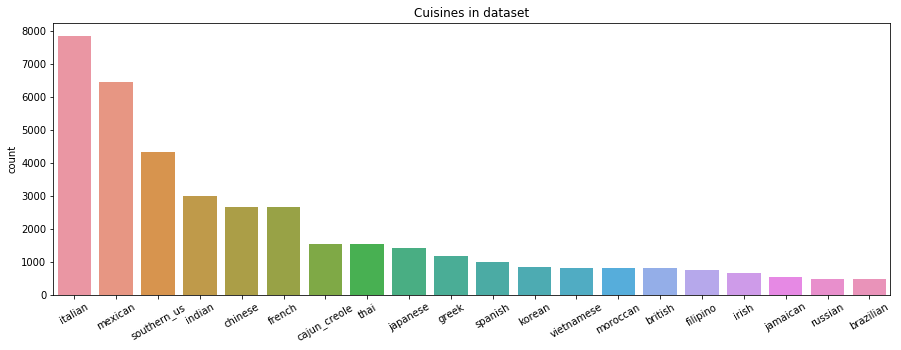

In [7]:
plt.figure(figsize = (15,5))
ax = sns.countplot(train['cuisine'], order = train['cuisine'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Cuisines in dataset')
ax.set_xlabel('');

### Exploring the relationship between recipe length and cuisine

We created a 'number of ingredients' feature, ie. how many ingredients appear in each recipe. We hypothesise that this may be a contributing factor when predicting cuisine.

In [8]:
train['number'] = [len(i) for i in train['ingredients']]
train.head()

,cuisine,id,ingredients,number
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


In [9]:
train['number'].describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: number, dtype: float64

The average recipe length is 11 ingredients. 

In [10]:
print('Maximum Number of Ingredients in a Dish: ',train['number'].max())
print('Minimum Number of Ingredients in a Dish: ',train['number'].min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


The longest recipe has 65 ingredients! The shortest has 1. In the below cell we can see that this longest recipe is in fact Italian. This is likely to be an outlier since Italian food is typically known for being simply, but with high quality and fresh ingredients.

In [11]:
print("Explore the ingredients in the longest recipe in our training set:" + "\n")
print(str(list(train[train['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("Cuisine: " + str(list(train[train['ingredients'].str.len() == 65].cuisine)))

Explore the ingredients in the longest recipe in our training set:

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pep

Now that we have created a number field , we can begin to explore the relationship between recipe complexity and cuisine. We already know that the longest recipe is Italian, but in the next section we also learn that, on average, the cuisines with the most ingredients are Moroccan (13), Indian (12), Vietanmese (12), Cajun (12) and Thai (12).

Brazilian, British, French, Irish, Japanese and Southern US recipes are typically the shortest. 

In [12]:
# create a dataframe grouped by cuisine to get average number of ingredients by cuisine, and sort

result = train.groupby(["cuisine"])['number'].mean().reset_index().sort_values('number', ascending = False)
result

,cuisine,number
14,moroccan,12.909866
7,indian,12.705961
19,vietnamese,12.675152
2,cajun_creole,12.617076
18,thai,12.545809
10,jamaican,12.214829
3,chinese,11.982791
12,korean,11.284337
13,mexican,10.877446
17,spanish,10.423660


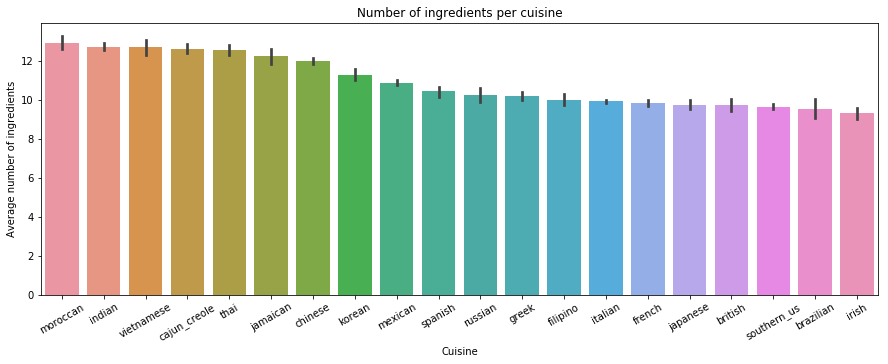

In [13]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x = 'cuisine', y = 'number', data = train, order = result['cuisine'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Number of ingredients per cuisine')
ax.set_ylabel('Average number of ingredients')
ax.set_xlabel('Cuisine');


### Dealing with 1-ingredient recipes

We have 22 recipes with only 1 ingredient. These 1-ingredient recipes are more likely to be Indian. A 1-ingredient recipe does not make much sense given the context of our study, and will mislead the algorithm to over-value these ingredients. We therefore discard these rows. 

In [14]:
train[train['number'] < 2]

,cuisine,id,ingredients,number
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


In [15]:
train[train['number'] < 2].shape

(22, 4)

In [16]:
train[train['number'] < 2].groupby('cuisine')['cuisine'].count()

cuisine
french         2
greek          1
indian         6
italian        1
japanese       3
mexican        2
southern_us    1
spanish        2
thai           3
vietnamese     1
Name: cuisine, dtype: int64

In [17]:
# removing 1-ingredient recipes leaves us with 39,752 observations

train = train[train['number'] > 1]
train.shape

(39752, 4)

### Exploring the most commonly used ingredients

Now we begin to look at the counts of different ingredients to understand which are most commonly used. Here we have to create a list storing all of the unique ingredients in our dataframe with duplicates, and then cast to a dataframe by grouping by ingredient and counting how many times each ingredient occurs. 

In [18]:
allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train['ingredients']:
    for ingr in item:
        allingredients.append(ingr) 

In [19]:
# converting to a dataframe 
ingredients_df = pd.DataFrame(allingredients, columns=['ingredient'])

In [20]:
# counting number of recipes with each ingredient
ingredients_df = ingredients_df.groupby('ingredient')['ingredient'].count().reset_index(name="count")
ingredients_df.head()

,ingredient,count
0,( oz.) tomato sauce,11
1,( oz.) tomato paste,9
2,(10 oz.) frozen chopped spinach,3
3,"(10 oz.) frozen chopped spinach, thawed and sq...",2
4,(14 oz.) sweetened condensed milk,2


In [21]:
# checking the modet commonly used 20 ingredients

print("The most commonly used ingredients (with counts) are:")
print("\n")
print(ingredients_df.nlargest(20, 'count'))
print("\n")
print("The number of unique ingredients in our training sample is: ", ingredients_df['ingredient'].nunique())

The most commonly used ingredients (with counts) are:


               ingredient  count
5309                 salt  18049
4343            olive oil   7972
4361               onions   7972
6435                water   7456
2884               garlic   7380
5888                sugar   6434
2890        garlic cloves   6237
1220               butter   4846
3135  ground black pepper   4785
555     all-purpose flour   4632
4569               pepper   4438
6375        vegetable oil   4384
2436                 eggs   3388
5744            soy sauce   3296
3591          kosher salt   3113
3102         green onions   3078
6146             tomatoes   3058
3641           large eggs   2948
1386              carrots   2814
6268      unsalted butter   2779


The number of unique ingredients in our training sample is:  6714


There are 6714 unique ingredients in our sample, and the most commonly used ingredients are salt, olive oil, onions and water. This is not suprising since these ingredients are flavour enhancers used across the globe. It is highly likely that these, along with the other most commonly used ingredients will have poor predictive power (we explore this in greater detail later using tf-idf).

In [22]:
# checking the ingredients that only occur in one recipe

print("Ingredients that only occur in 1 recipe are:")
print("\n")
print(ingredients_df[ingredients_df['count'] == 1])

Ingredients that only occur in 1 recipe are:


                                             ingredient  count
12                             2% low fat cheddar chees      1
15                   2% milk shredded mozzarella cheese      1
18                      33% less sodium cooked deli ham      1
19                           33% less sodium cooked ham      1
21              33% less sodium smoked fully cooked ham      1
25                    8 ounc ziti pasta, cook and drain      1
27                         A Taste of Thai Rice Noodles      1
29                          Adobo All Purpose Seasoning      1
31                                  Alexia Waffle Fries      1
33                                     Amarena cherries      1
38                                     Argo Corn Starch      1
40                              Asian sweet chili sauce      1
41                               Azteca Flour Tortillas      1
42                        BACARDI® Mixers Margarita Mix      1
43      

A large number of ingredients (1759) only appear in one recipe. This is partly because they are very specific ingredients, and many include brand names. We will not try to harmonize these now. These ingredients are likely to have stronger predictive power when predicting cuisine. 

### How many and which ingredients can be found in each cuisine

Now we would like to learn more about the variety of ingredients used in different cuisines. Some questions we want to answer:
* Do Indian recipes typically call for the same set of spices? 
* Does the lower number of ingredients per recipe for Japanese cuisine mean that there are fewer ingredients used in Japanese cooking overall?
* Does fewer recipes mean fewer ingredients? Will Italian cuisine have the most ingredients because we also have the highest number of recipes in our sample?

In [23]:
# Define a function that returns how many different ingredients can be found in all recipes for a given cuisine

def findnumingr(cuisine):
    listofinrg = []
    for item in train[train['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            listofinrg.append(ingr)
    result = (cuisine,len(list(set(listofinrg))))         
    return result 

In [24]:
# Iterate over each cuisine and add cuisines + total ingredients used to our list

cuisineallingr = []
for cuisine in train['cuisine'].unique():
    cuisineallingr.append(findnumingr(cuisine))

In [25]:
cuisineallingr.sort(key=lambda x: x[1])
cuisineallingr

[('brazilian', 853),
 ('russian', 872),
 ('jamaican', 877),
 ('korean', 898),
 ('filipino', 947),
 ('moroccan', 974),
 ('irish', 999),
 ('vietnamese', 1108),
 ('british', 1166),
 ('greek', 1198),
 ('spanish', 1263),
 ('thai', 1375),
 ('japanese', 1439),
 ('cajun_creole', 1576),
 ('indian', 1664),
 ('chinese', 1792),
 ('french', 2102),
 ('southern_us', 2462),
 ('mexican', 2684),
 ('italian', 2929)]

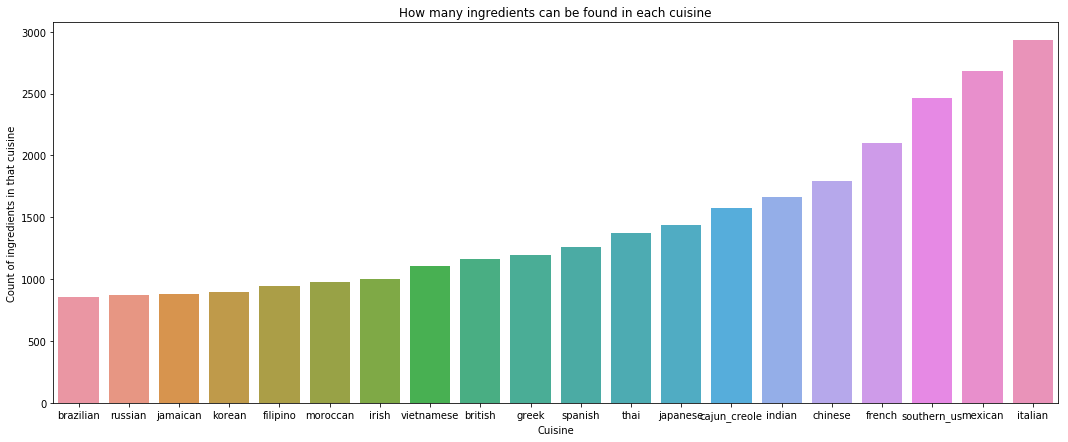

In [26]:
plt.figure(figsize=(18, 7))
sns.barplot(y = [i[1] for i in cuisineallingr], 
           x = [i[0] for i in cuisineallingr],
           order = cuisineallingr.sort(key=lambda x: x[1], reverse = False))
plt.xlabel('Cuisine')
plt.ylabel('Count of ingredients in that cuisine')
plt.title('How many ingredients can be found in each cuisine');

From the above bar chart, we can see that cuisines with more recipes in the training set do not always have more ingredients representing them.  For example, French cuisine is only 6.65% of he training set, but has more variability than Indian cuisine (which makes up 7.5%). 

As expected, however, Italian cuisine has the greatest range of ingredients. This is likely because we have such a large number of Italian recipes in our sample.

Now, we explore which ingredients are specific only to ONE cuisine (and will therefore have strong predictive power.)

In [27]:
# We used allingredients before (it's a list of all ingredients in the training sample, with duplication)
# Now we remove duplicates
allingredients = list(set(allingredients))

In [28]:
# Define a function that returns a dataframe with top 5 unique ingredients in a given cuisine 
def cuisine_unique(cuisine, allingredients):
    allother = []
    
    # create a list of ingredients that appear in other cuisines
    for item in train[train['cuisine'] != cuisine]['ingredients']:
        for ingr in item:
            allother.append(ingr)
    allother  = list(set(allother ))
    
    # compare allother to the full list in allingredients, and only keep ingredients that aren't in allother
    specificnonly = [x for x in allingredients if x not in allother]
    
    mycounter = Counter()
    
    # for every ingredient that appears in that cuisine, find number of associated recipes in that cuisine
    for item in train[train['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            mycounter[ingr] += 1
    keep = list(specificnonly)
    
    # only keep the recipe counts if that ingredient is unique to the cuisine
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    # create a dataframe that shows the recipe count for each ingredient unique to the cuisine
    cuisinespec = pd.DataFrame(mycounter.most_common(5), columns = ['ingredient','count'])
    cuisinespec['Cuisine'] = cuisine
    
    return cuisinespec

In [29]:
cuisine_unique('italian', allingredients)

,ingredient,count,Cuisine
0,gnocchi,41,italian
1,"lasagna noodles, cooked and drained",26,italian
2,bulk italian sausag,21,italian
3,potato gnocchi,20,italian
4,cheese ravioli,18,italian


So here we can see that gnocchi is the most unique ingredient to Italian cuisine. It appears in no other cuisines, but in 41 Italian recipes. This is followed by lasagne noodles. 

In [30]:
# Now create a new dataframe with all of this information

unique_ing = pd.DataFrame()

for i in train['cuisine'].unique():
    unique_ing = unique_ing.append(cuisine_unique(i, allingredients))

In [31]:
unique_ing

,ingredient,count,Cuisine
0,ouzo,10,greek
1,kefalotyri,9,greek
2,greek-style vinaigrette,5,greek
3,pita loaves,5,greek
4,sliced kalamata olives,4,greek
0,collards,14,southern_us
1,buttermilk biscuits,12,southern_us
2,Nilla Wafers,10,southern_us
3,grit quick,8,southern_us
4,peaches in heavy syrup,6,southern_us


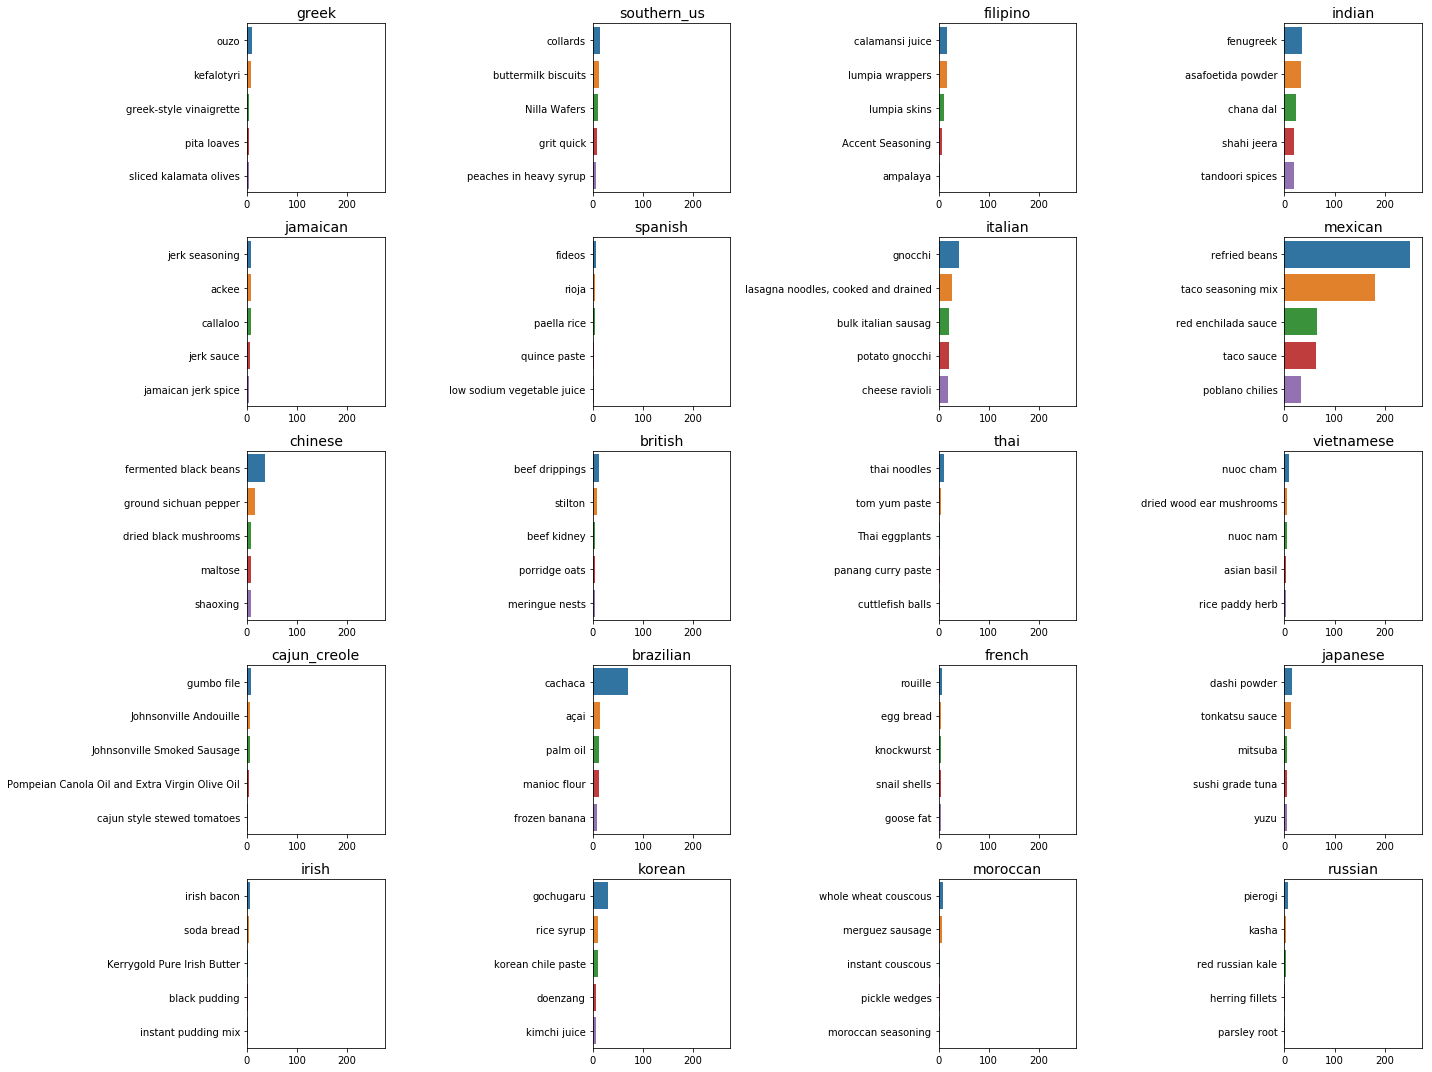

In [32]:
# plotting with each cuisine on the same xlim

fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, unique_ing['Cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'count', 
                data = unique_ing[unique_ing['Cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0, 275)

plt.tight_layout()
#plt.title('Unique ingredients per cuisine');

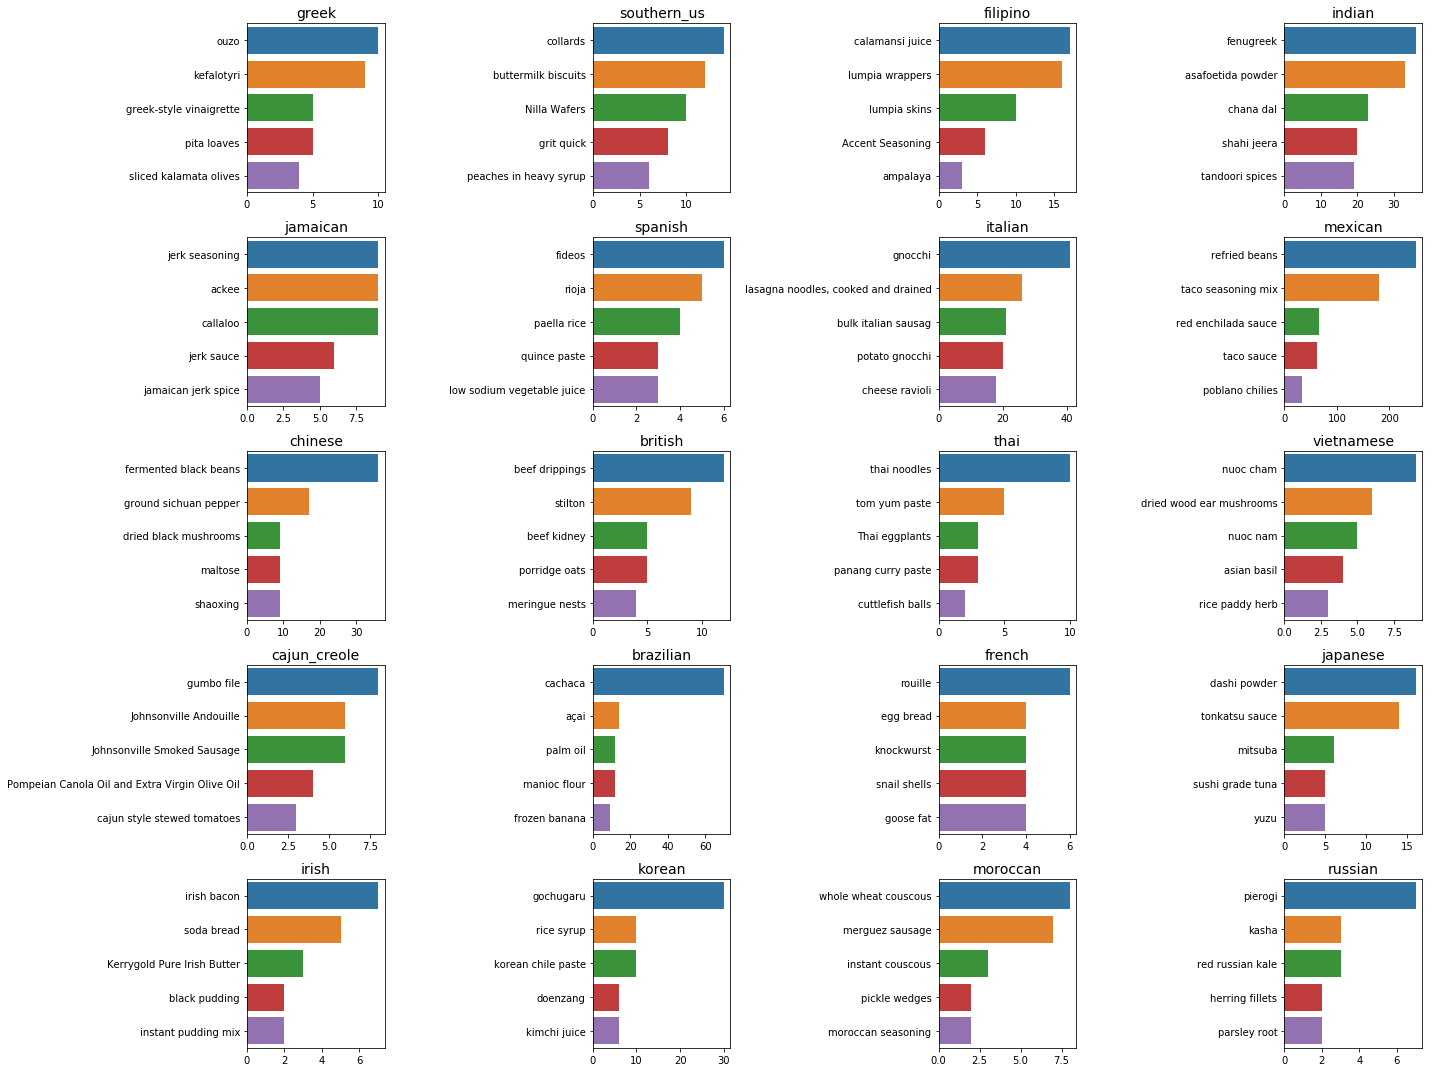

In [33]:
# And then again without forcing the xlim

fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, unique_ing['Cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'count', 
                data = unique_ing[unique_ing['Cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
#plt.title('Unique ingredients per cuisine');

The above plots show us quite a bit about how differentiated the cuisines are, and give us an indication of how easy/hard it will be to predict a cuisine based on its ingredients. 

* Mexican cuisine is the only one where the unique ingredients (mainly refried beans) are also highly represented across Mexican recipes; refried beans are found in more than 200 Mexican recipes in our dataset. We can expect that refried beans and taco seasoning will play an important role in predicting whether a cuisine is Mexican. 
* Cachaca is the next most important predictor for a cuisine, with more than 60 Brazilian recipes calling for this spirit
* Gnocchi is an important unique ingredient for Italian food (unsuprisingly) 
* Fenugreek is important and unique to Indian food
* Fermented black-beans is important for Chinese cuisine
* Gochugaru is unique to Korean
* The remaining cuisines may be harder to accurately predict based on ingredient presence, they had fewer recipes with ingredients unique to their style of cooking. 

We will drill in to this further using TfIdf, and of course, validate how well our cuisines can be predicted once we begin ML.

# Tf-Idf

Now that we have explored the data and begun to understand some preliminary differences between the cuisines in terms of number of ingredients and key ingredients used, we can apply the tf-idf approach.  This allows us to uncover which ingredients are important to a specific cuisine, within our whole dataset. These will be ingredients that are frequently used in the recipes belonging to that cuisine and at the same time not so frequently used in the whole sample of recipes. 

In our case:
* Corpus = the What's cooking dataset
* Document = recipe
* Word = ingredient

Note that we are using the data as is - we have removed 1-ingredient recipes, and converting to lowercase, but that is the only cleaning. 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
# list of all the recipes

features = [] 
for item in train['ingredients']:
    features.append(item)
len(features)

39752

In [36]:
# this is our vocabulary; all ingredients from all recipes (with duplicates)

ingredients = [] 
for item in train['ingredients']:
    for ingr in item:
        ingredients.append(ingr) 
len(ingredients)

428253

#### Further preparing the data

We need to transform our ingredients such that they are in a cleaner format. We will do some final transformations on the data here, including: 
* converting all words to lower case;
* removing punctuation and special characters
* removing units of measurement to remove noise 


In [37]:
# Reminder of our features variable

features

[['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles'],
 ['plain flour',
  'ground pepper',
  'salt',
  'tomatoes',
  'ground black pepper',
  'thyme',
  'eggs',
  'green tomatoes',
  'yellow corn meal',
  'milk',
  'vegetable oil'],
 ['eggs',
  'pepper',
  'salt',
  'mayonaise',
  'cooking oil',
  'green chilies',
  'grilled chicken breasts',
  'garlic powder',
  'yellow onion',
  'soy sauce',
  'butter',
  'chicken livers'],
 ['water', 'vegetable oil', 'wheat', 'salt'],
 ['black pepper',
  'shallots',
  'cornflour',
  'cayenne pepper',
  'onions',
  'garlic paste',
  'milk',
  'butter',
  'salt',
  'lemon juice',
  'water',
  'chili powder',
  'passata',
  'oil',
  'ground cumin',
  'boneless chicken skinless thigh',
  'garam masala',
  'double cream',
  'natural yogurt',
  'bay leaf'],
 ['plain flour',
  'sugar',
  'butter',
  'eggs',
  'fresh ginger root',
  'salt',
  'ground 

In [47]:
import re

features_processed= [] # here we will store the preprocessed training features
for item in features:
    newitem = []
    for ingr in item:
        ingr.lower() # Case Normalization - convert all to lower case 
        ingr = re.sub("[^a-zA-Z]"," ",ingr) # Remove punctuation, digits or special characters 
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) # Remove different units  
        newitem.append(ingr)
        string = ' '.join(newitem) # flatten our list of lists to an acceptable input for tfidf
    features_processed.append(string)

In [55]:
features_processed

['romaine lettuce black olives grape tomatoes garlic pepper purple onion seasoning garbanzo beans feta cheese crumbles',
 'plain flour ground pepper salt tomatoes ground black pepper thyme eggs green tomatoes yellow corn meal milk vegetable oil',
 'eggs pepper salt mayonaise cooking oil green chilies grilled chicken breasts garlic powder yellow onion soy sauce butter chicken livers',
 'water vegetable oil wheat salt',
 'black pepper shallots cornflour cayenne pepper onions garlic paste milk butter salt lemon juice water chili powder passata oil ground cumin boneless chicken skinless thigh garam masala double cream natural yogurt bay leaf',
 'plain flour sugar butter eggs fresh ginger root salt ground cinnamon milk vanilla extract ground ginger powdered sugar baking powder',
 'olive oil salt medium shrimp pepper garlic chopped cilantro jalapeno chilies flat leaf parsley skirt steak white vinegar sea salt bay leaf chorizo sausage',
 'sugar pistachio nuts white almond bark flour vanilla e

Note, we know that by flattening the data like this we lose the value from multi word ingredients, eg. 'grape tomatoes', or 'feta cheese'. To solve this, we could use bi-grams or tri-grams in our tf-idf. We chose to stick with unigrams just for simplicity. We acknowledge that this would be an important next step to further improve our models. 

In [56]:
# Fit the TfidfVectorizer to data

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(features_processed) # X_tr - matrix of tf-idf scores
feature_names = tfidf.get_feature_names()


# Define the target variable

cuisine = train['cuisine']

In [57]:
X_tfidf

<39752x2996 sparse matrix of type '<class 'numpy.float64'>'
	with 762207 stored elements in Compressed Sparse Row format>

In [58]:
# Define a function for finding the most important features in a given cuisine according to Tf-Idf measure 
# We want to look at features only that have a min tfidf of 0.1 (ie. ignore any poor indicators of cuisine)
# We want to return the top 10 most important words/ingredients
# The output is a list of dataframes, one per cuisine, with top  ingredients

def top_feats_by_class(train, target, featurenames, min_tfidf=0.1, top_n=10):

    dfs = pd.DataFrame()
    labels = np.unique(target)
    
    for label in labels: # for each cuisine
        
        ids = np.where(target==label) 
        D = train[ids].toarray() # creates an array of ingredients from our matrix of tfidf scores related to the cuisine
        D[D < min_tfidf] = 0 # keeps only the ingredients that have tfidf greater than 0.1
        tfidf_means = np.nanmean(D, axis=0) # takes the average tfidf for each ingredient 
        
        topn_ids = np.argsort(tfidf_means)[::-1][:top_n] #  Get top n tfidf values
        top_feats = [(featurenames[i], tfidf_means[i]) for i in topn_ids] # find their corresponding feature names
        df = pd.DataFrame(top_feats) # put this all into a df 
        df.columns = ['ingredient', 'tfidf'] # rename for readability
        
        df['cuisine'] = label
        dfs = dfs.append(df)
        
    return dfs

In [59]:
result_tfidf = top_feats_by_class(X_tfidf, cuisine, feature_names, min_tfidf=0.1, top_n=5)
result_tfidf

,ingredient,tfidf,cuisine
0,milk,0.090126,brazilian
1,cachaca,0.081215,brazilian
2,lime,0.075845,brazilian
3,coconut,0.065276,brazilian
4,condensed,0.054580,brazilian
0,flour,0.089259,british
1,butter,0.077728,british
2,milk,0.069785,british
3,eggs,0.068302,british
4,sugar,0.067008,british


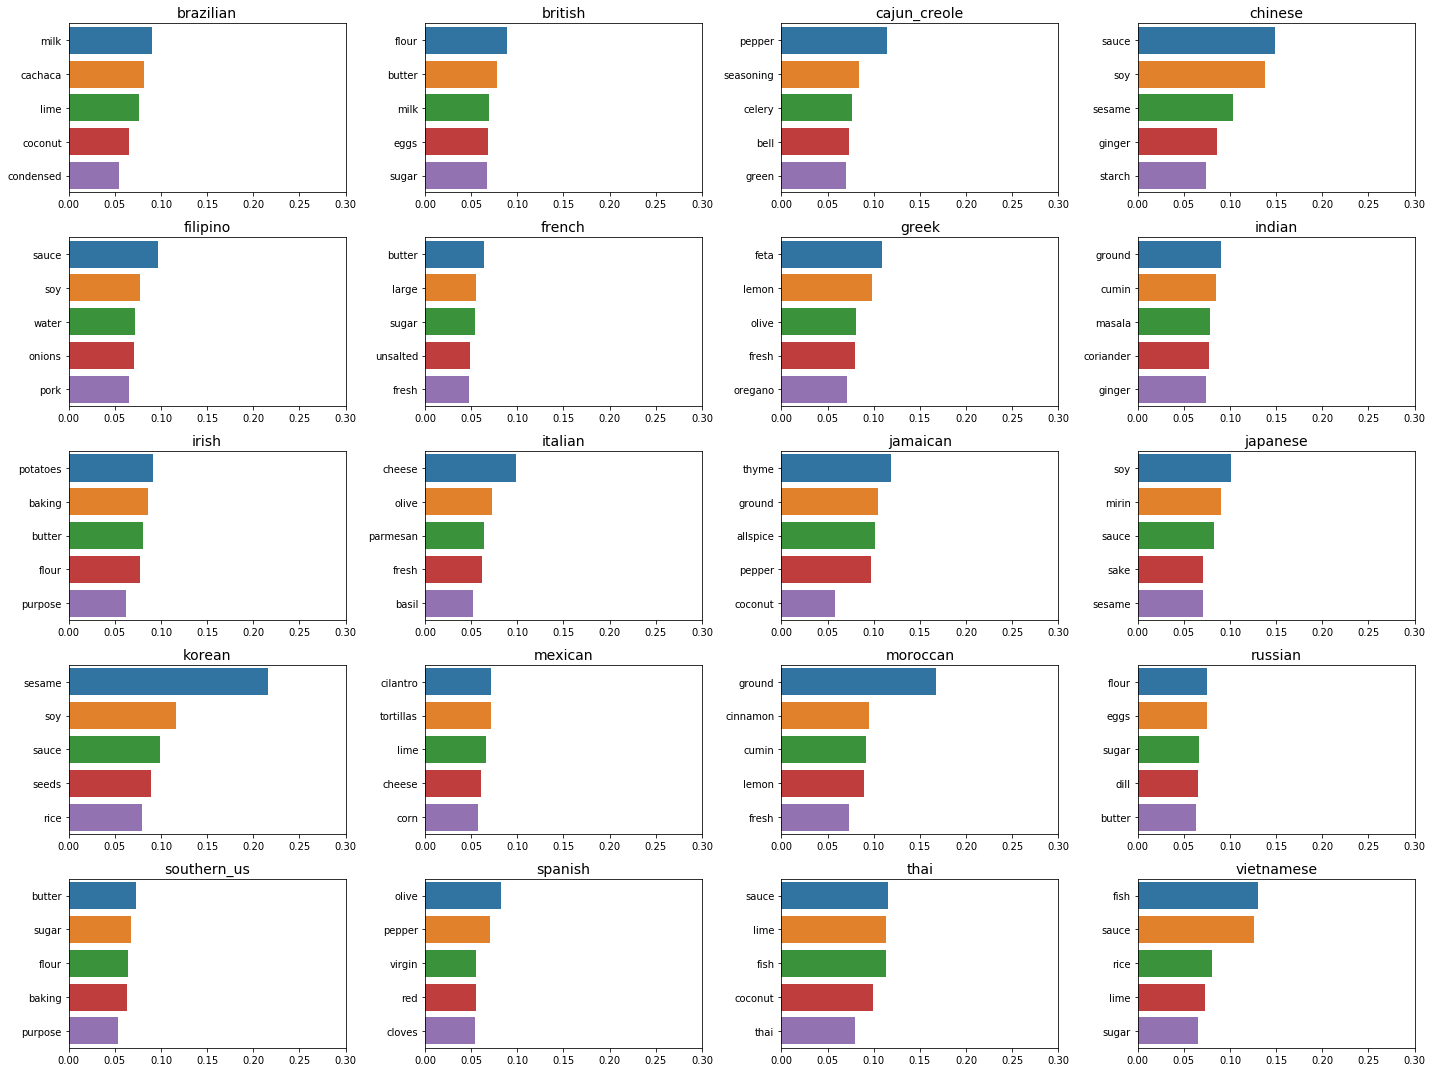

In [60]:
fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, result_tfidf['cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'tfidf', 
                data = result_tfidf[result_tfidf['cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0, .3)

plt.tight_layout();
#plt.title('Ingredient importance based on tfidf');

From the visualizations above we can make the following observations: 

* Some of our assumptions from earlier EDA were correct: 
    * Cachaca is major ingredient in Brazilian recipes
    * Tortillas are important in Mexican cuisine
* Some seemingly innocuous ingredients are rated highly by tf-idf:
    * Milk in Brazilian food
    * Butter for Southern_US
    * Flour for British and Russian
    * etc.
* Some important words appear in many cuisines:
    * Sauce, fish, soy, sesame have strong tf-idf values in Chinese, Japanese, Vietnames, Thai, Filipino and Korean foods. 
    * Butter flour and sugar are important in both British, French and Irish cuisines.
    * Spanish, Italian and Greek are clearly all Mediterranean cusines, all using a combination of oil, garlic, pepper and cheese.
    * Moroccan, Indian and Jamaican cuisine rely more heavily on spices.

# Machine Learning

Now that we have conducted some in-depth EDA and have a better understanding of the ingredients and cuisines in our data, we are ready to apply some Machine Learning.  We want to build the best model to predict a recipe's cuisine based on the ingredients in the recipe.  

This is a classification challenge. To solve this challenge, we will apply the following ML techniques using out TF-IDF vecotized data, as prepared earlier:
* Logistic Regression
* Random Forest
* Support Vector Machine

We will vectorize our original data using CountVectorizer so that the values are all positive and represent incidence/counts, and then apply:
* Multinomial Naive Bayes

More detailed explanation for why we have selected each algorithm is provided in the relevant section.


#### A note on unbalanced data

As we learned during the EDA, the sample data is unbalanced (see counts below). We have a high percentage of Italian recipes relative to all other cuisines. When we first approached ML, we felt that it was necessary to rebalance the data to minimise bias towards Italian recipes and low recall for non-Italian recipes. We believed this was particularly important because we know that Random Forests and SVMs are particularly sensitive to unbalanced data.

We originally applied SMOTE. It creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records. We ran our model training and cross-validation on this adjusted dataset, but it made our dataset too large to manage and created noise. It had a negative impact on the overall accuracy of our models. 

Next, to avoid losing potentially useful data, we instead used the Cluster Centroids technique for undersampling. This method undersamples the majority class by replacing a cluster of majority samples This method finds the clusters of majority class with K-mean algorithms. Then it keeps the cluster centroids of the N clusters as the new majority samples. We found that this also resulted in poor accuracy across all algorithms that we attempted. 

There is lots of research stating that under- or over-sampling does not necessarily improve model performance. There are specific cases where it can be beneficial, but given the poor accuracies that we found, we concluded that this was not one of those cases. In the end, we  decided to proceed with the original unbalanced data. 

_See the code that we tried (but didn't use) at the bottom of this notebook._

#### A note on dimensionality reduction

With the data cleaning and vectorization, our data contains 2996 features. This is a large number of features, and certainly a candidate for dimensionality reduction.  We originally applied TruncatedSVD on the Tf-Idf data (because TruncatedSVD works better with sparse matrices). We still needed ~1000 features (words) to retain >90% cumulative explained variance. Training was not significantly faster with this reduced dataset, so we decided to proceed with training our models on all features without dimensionality reduction.

_See the code that we tried (but didn't use) at the bottom of this notebook._

In [282]:
scipy.stats.itemfreq(y_train)

array([['brazilian', 304],
       ['british', 545],
       ['cajun_creole', 1037],
       ['chinese', 1807],
       ['filipino', 507],
       ['french', 1785],
       ['greek', 790],
       ['indian', 2057],
       ['irish', 450],
       ['italian', 5200],
       ['jamaican', 355],
       ['japanese', 958],
       ['korean', 583],
       ['mexican', 4312],
       ['moroccan', 529],
       ['russian', 321],
       ['southern_us', 2839],
       ['spanish', 670],
       ['thai', 1030],
       ['vietnamese', 554]], dtype=object)

#### Splitting the data for cross-validation

First, we split our data into a train set and a test set for cross validation. For each model that we train on our train set, we will test the model on our test set to:

1) check the model's accuracy in practice / generalizability

2) check for overfitting

We are creating this split now, and will hold it constant across the ML model training to ensure comparability across the models that we train.

Note, we don't need to label encode our y since this is in-built in scikit lear algorithms. We also want to retain the labels so we can interpret our confusion matrices and classification reports. 

In [201]:
# our X variable

X_tfidf.shape

(39752, 2996)

In [273]:
# our y variable

y = train['cuisine'] 
y.shape

(39752,)

In [204]:
from sklearn.model_selection import train_test_split

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

Let's confirm that everything has worked...

In [206]:
print(X_train.shape)
print(y_train.shape)

(26633, 2996)
(26633,)


In [66]:
print(X_test.shape)
print(y_test.shape)

(13119, 2996)
(13119,)


#### Timeit

We will be using some computationally-heavy approaches, and so we want to time how long each model takes. The timeit library will help us here.

In [207]:
import time
start_time = time.time()

### Logistic Regression

We will begin with Multinomical Logistic Regression because it is arguable the simplest and more intuitive classifier model that we have learnt. 

In [318]:
# import algorithm

from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

In [319]:
# train model

log.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 89682.03 seconds ---


In [320]:
# apply model to test set and get predictions

log_preds = log.predict(X_test)

In [321]:
# import metrics to evaluate our model

from sklearn.metrics import classification_report, accuracy_score
from pandas_ml import ConfusionMatrix # this is awesome for formatting more complex confusion matrices

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.73      0.39      0.51       163
     british       0.63      0.29      0.39       259
cajun_creole       0.78      0.67      0.72       509
     chinese       0.78      0.88      0.83       866
    filipino       0.79      0.57      0.66       248
      french       0.58      0.61      0.60       859
       greek       0.81      0.68      0.74       384
      indian       0.85      0.91      0.88       940
       irish       0.69      0.42      0.52       217
     italian       0.78      0.90      0.84      2637
    jamaican       0.86      0.60      0.71       171
    japanese       0.86      0.68      0.76       462
      korean       0.81      0.71      0.76       247
     mexican       0.88      0.93      0.91      2124
    moroccan       0.87      0.71      0.78       292
     russian       0.69      0.26      0.38       168
 southern_us       0.67      0.82      0.74      1480

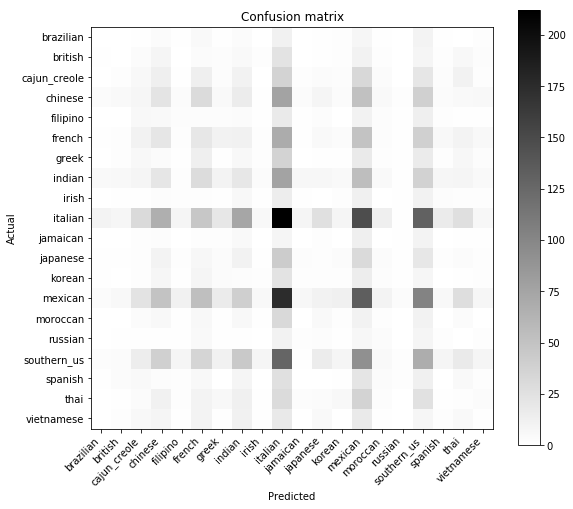

In [322]:
# cross validation
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, log_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, log_preds))
print('\n')
ConfusionMatrix(y_test, log_preds).plot();

We can see from the above that our log model has strong precision for Mexican, Moroccan, Jamaican and Japanese food. This makes sense when we remember from our EDA that these cuisines had higher counts of recipes containing ingredients that were totally unique to the cuisine. Recall for Italian food, however, is lower. Italian recipes are often wrongly predicted to be Mexican or Southern_US. This also makes sense when we remember that Italian cuisine had the most diverse set of ingredients. 

The biggest flaws for this model are recall, and particularly for Brazilian, British, Irish, Russian and Spanish food; these recipes are all often mis-categorised as something they are not.

Overall, performance for this model is average. An accuracy score of 77% is below our expectations, so let's keep going!

#### Logistic Regression with Randomized Search

Let's try to further improve our logistic regression model by hypertuning the parameters and applying a randomized search.

The parameter that we are most interesting in tuning is C, our regularization parameter. We will try a range of C options, from very small (where we increase the regularization strength which will create simpler models that underfit), to very large (where we lower the regularization and increase model complexity). 

In [323]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
import scipy

In [324]:
# Specifying the parameter range for testing
# We want our random search to check a range of C values along exponetial continuous variable

param_dist = {'C' : scipy.stats.expon(scale=1.0)}

In [326]:
# Running the Grid Search, prioritising accuracy

log_rand_search = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_dist, scoring = 'accuracy')

In [327]:
# fit the different combinations of 

log2 = log_rand_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 89785.12 seconds ---


In [328]:
# specify the best model

log_best = log_rand_search.best_estimator_
log_best

LogisticRegression(C=1.8024127702165738, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Our best logistric regression model has a C of 1.8024. Let's re-run this model on our training set and check it's generalizability on the test set.

In [329]:
log_best.fit(X_train,y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 89810.35 seconds ---


In [330]:
log_best_preds = log_best.predict(X_test)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.74      0.47      0.58       163
     british       0.60      0.32      0.42       259
cajun_creole       0.81      0.70      0.75       509
     chinese       0.79      0.88      0.83       866
    filipino       0.78      0.60      0.68       248
      french       0.59      0.62      0.61       859
       greek       0.81      0.71      0.75       384
      indian       0.86      0.91      0.88       940
       irish       0.68      0.46      0.55       217
     italian       0.79      0.90      0.84      2637
    jamaican       0.86      0.65      0.74       171
    japanese       0.86      0.69      0.76       462
      korean       0.82      0.73      0.78       247
     mexican       0.89      0.93      0.91      2124
    moroccan       0.86      0.74      0.79       292
     russian       0.64      0.31      0.42       168
 southern_us       0.69      0.82      0.75      1480

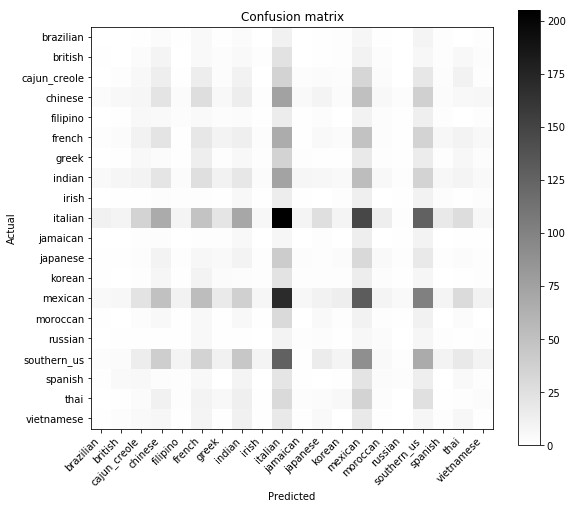

In [331]:
# cross validation
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, log_best_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, log_best_preds))
print('\n')
ConfusionMatrix(y_test, log_best_preds).plot();

Our best Logistic Regression model has an accuracy of 78%, which is slightly better. 

We still have issues with precision (British and French in particular) and recall (Spanish, British and Russian in particular). We will try some different algorithms.

### Random Forest

Random Forest makes sense to try for this challenge because these models have the potential to identify specific relationships in the data. Tree-based classifiers capture non-linearity and interactions between features that linear models (like logistic regression from above) cannot capture. 

They do, of course, have the potential to overfit, so we will be sure to add stopping criteria and pay close attention to the cross-validation when we apply our Grid Search.

In [265]:
# import algorithm

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [266]:
# train model

rfc.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 41655.3 seconds ---


In [255]:
# apply model to test set and get precitions

rfc_preds = rfc.predict(X_test)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.64      0.48      0.55       163
     british       0.40      0.24      0.30       259
cajun_creole       0.65      0.61      0.63       509
     chinese       0.65      0.85      0.74       866
    filipino       0.56      0.41      0.47       248
      french       0.46      0.48      0.47       859
       greek       0.71      0.58      0.64       384
      indian       0.73      0.87      0.79       940
       irish       0.50      0.29      0.37       217
     italian       0.70      0.86      0.77      2637
    jamaican       0.86      0.38      0.53       171
    japanese       0.76      0.56      0.64       462
      korean       0.79      0.54      0.64       247
     mexican       0.81      0.89      0.85      2124
    moroccan       0.81      0.51      0.63       292
     russian       0.52      0.16      0.25       168
 southern_us       0.65      0.66      0.66      1480

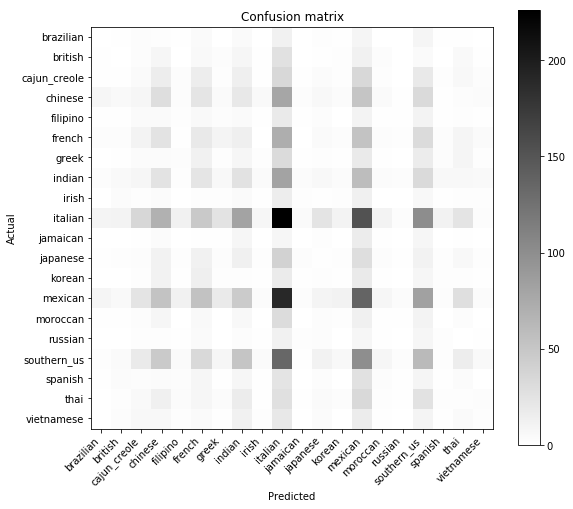

In [257]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, rfc_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, rfc_preds))
print('\n')
ConfusionMatrix(y_test, rfc_preds).plot();

This default random forest has performed quite poorly. Let's tune the hyperparameters and see how we can improve. 

#### Random Forest with Grid Search

Let's try to further improve our Random Forest Classifier by tuning the parameters and applying a grid search.

We attempted running the Random Forest grid search with options for all (or almost all) of the possible hyperparameters. This was incredible computationally draining and took hours, so we instead reduced our interest range down to the below four hyperparameters. They provide stopping criteria (max depth and max features), trial different levels of randomness (through bootstrapping options) and also test based on different complexity levels (through n estimators).

**bootstrap:** If we turn off bootstrapping, all of the data is used to fit the model. This means there is no randomness between trees with respect to sampling. 

**max_depth:** The deeper the tree, the more splits it has and it captures more information about the data. We'll try a few different options here.

**max_features:** This is another stopping criteria that randomly subsample max features to choose the best one for the split. Auto means all the features are considered, while sqrt means the squareroot of the number of features is considered.

**n_estimators:** This tells the model how many unique decision trees to consider when building our model. We're going to try up to 500 to see how it impacts. 

In [260]:
# specifying the parameters we want to test

bootstrap = [True, False]
max_depth = [10, 30, 50, 70, None]
max_features = ['auto', 'sqrt']
n_estimators = [100,200,500,700]

In [261]:
# building parameter grid

rfc_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [262]:
# running the grid search

rfc_grid_search = GridSearchCV(RandomForestClassifier(), param_grid=rfc_param_grid, scoring="accuracy")

In [263]:
# fit the grid search combinations

rfc2 = rfc_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 41651.22 seconds ---


In [264]:
# learn the best hyperparameters

print(rfc2.best_score_)
print(rfc2.best_params_)

0.741561221041565
{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 700}


Our best Random Forest model has the following hyperparameters:
* n_estimators = 700
* max_features = 'auto'
* max_depth = None
* bootstrap = False

Let's re-run this model on our training set and check it's generalizability on the test set.

In [274]:
# specify the best model

rfc_best = RandomForestClassifier(n_estimators = 700, bootstrap=False, max_depth=None, max_features='auto')

In [275]:
rfc_best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [276]:
rfc_best_preds=rfc_best.predict(X_test)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.78      0.45      0.57       163
     british       0.73      0.25      0.38       259
cajun_creole       0.84      0.67      0.75       509
     chinese       0.74      0.89      0.81       866
    filipino       0.87      0.52      0.65       248
      french       0.61      0.55      0.58       859
       greek       0.83      0.62      0.71       384
      indian       0.81      0.93      0.86       940
       irish       0.74      0.35      0.47       217
     italian       0.73      0.92      0.81      2637
    jamaican       0.95      0.50      0.66       171
    japanese       0.86      0.64      0.73       462
      korean       0.88      0.68      0.77       247
     mexican       0.84      0.94      0.88      2124
    moroccan       0.88      0.66      0.75       292
     russian       0.79      0.24      0.37       168
 southern_us       0.67      0.79      0.72      1480

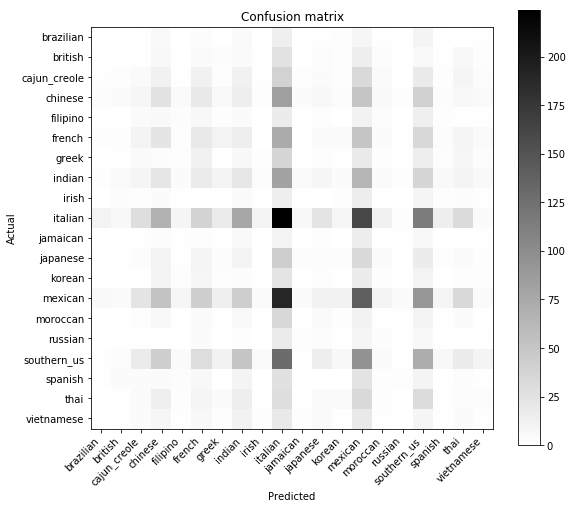

In [277]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, rfc_best_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, rfc_best_preds))
print('\n')
ConfusionMatrix(y_test, rfc_best_preds).plot();

The tuned random forest performs notably better than the default, but it's accuracy is still slightly below what we found with logistic regression. The random forest struggles with recall of British, Russian, Irish and Spanish. 

It's interesting to note that in all models so far, recall for Italian has been much stronger than precision. This does suggest that our models are biased towards predicting Italian even when the ingredients may not be totally indicative of an Italian recipe - the models seem to be overfitting on this highly represented class (as we expected).

### Support Vector Machine

SVMs are the next logical algorithm to apply because they have been applied with success to text classification in countless other examples. An SVM helps us to find the decision boundary between two classes, that is as far from any point in the training data as possible. In the context of the What's Cooking challenge, the ability to apply kernel tricks will be particularly interesting, since our cuisines clearly are not linearly separable given the high levels of overlap of ingredients across cuisines. 

In [332]:
# import the algorithm

from sklearn.svm import SVC
svc = SVC()

In [333]:
# train the model

svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [334]:
# apply model to test set and get predictions

svc_preds = svc.predict(X_test)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       163
     british       0.00      0.00      0.00       259
cajun_creole       0.00      0.00      0.00       509
     chinese       0.00      0.00      0.00       866
    filipino       0.00      0.00      0.00       248
      french       0.00      0.00      0.00       859
       greek       0.00      0.00      0.00       384
      indian       0.00      0.00      0.00       940
       irish       0.00      0.00      0.00       217
     italian       0.20      1.00      0.33      2637
    jamaican       0.00      0.00      0.00       171
    japanese       0.00      0.00      0.00       462
      korean       0.00      0.00      0.00       247
     mexican       0.00      0.00      0.00      2124
    moroccan       0.00      0.00      0.00       292
     russian       0.00      0.00      0.00       168
 southern_us       0.00      0.00      0.00      1480

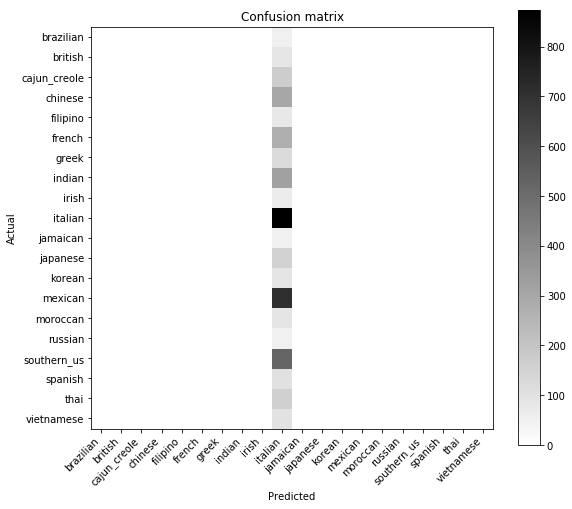

In [335]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, svc_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, svc_preds))
print('\n')
ConfusionMatrix(y_test, svc_preds).plot();

Clearly we have major problems with the default SVC model. This is almost definitely because out default kernel trick is rbf, which does not handle text classification or unbalanced data well. It is totally biased towards Italian.

#### SVC with Grid Search

Let's try to further improve our SVC by tuning the parameters and applying a grid search. The parameters that we are interested in trying are: 

**kernel trick:** If our data is not linearly separable in our default space, a kernel trick will transform the data into a higher dimensional space where there is aclear dividing margin between classes of data. It seems that the linear kernel is commonly used for text classification. We attempted rbf, but further research showed that it is in fact a poor choice for text classification, plus it is very computationally expensive. 

**C:** The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, a smaller-margin hyperplane will be used if that hyperplane does a better job of getting all the training points classified correctly. Conversely, for very small values of C our model will look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. 


In [288]:
# specifying the parameters we want to test

kernel = ['linear']
C = [0.01, 0.1, 1, 10, 100]

In [289]:
# building parameter grid

svc_param_grid = {'kernel': kernel,
               'C': C}

In [290]:
# running the grid search

svc_grid_search = GridSearchCV(SVC(), param_grid=svc_param_grid, scoring="accuracy")

In [291]:
# fit the grid search combinations

svc2 = svc_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 81220.86 seconds ---


In [299]:
# learn the best set of hyperparameters

print(svc2.best_score_)
print(svc2.best_params_)

0.7729883978522886
{'C': 1, 'kernel': 'linear'}


The best C value is 1, meaning that our optimizer is moderately sensitive to outliers, but does not try too hard to perfectly classify every point.

In [300]:
# specify the best model

svc_best = SVC(kernel = 'linear', C = 1)

In [301]:
svc_best.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 81630.48 seconds ---


In [302]:
svc_best_preds = svc_best.predict(X_test)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.72      0.54      0.62       163
     british       0.54      0.39      0.46       259
cajun_creole       0.77      0.72      0.75       509
     chinese       0.77      0.88      0.82       866
    filipino       0.74      0.61      0.67       248
      french       0.58      0.66      0.62       859
       greek       0.80      0.71      0.75       384
      indian       0.86      0.91      0.88       940
       irish       0.66      0.52      0.58       217
     italian       0.81      0.88      0.85      2637
    jamaican       0.88      0.67      0.76       171
    japanese       0.86      0.68      0.76       462
      korean       0.83      0.74      0.78       247
     mexican       0.91      0.92      0.91      2124
    moroccan       0.85      0.76      0.81       292
     russian       0.69      0.35      0.46       168
 southern_us       0.71      0.81      0.75      1480

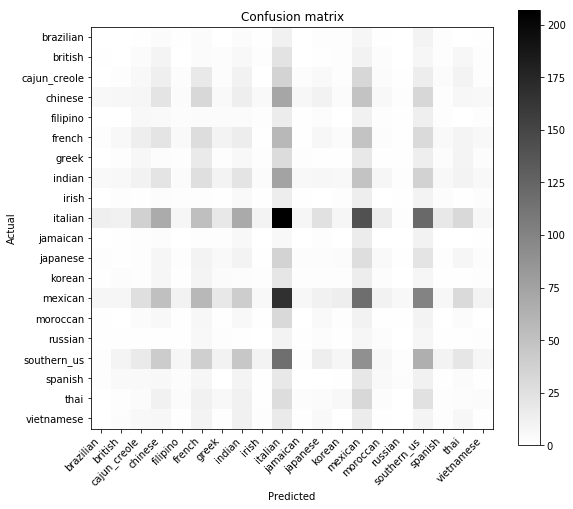

In [303]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, svc_best_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, svc_best_preds))
print('\n')
ConfusionMatrix(y_test, svc_best_preds).plot();

The SVC with a linear kernel and a C of 1 clearly performs well. We continue to have the same issues with recall for certain cuisines, but this is a contender for best model.

#### Trialling a OneVsRest approach

The deafault SVM algorithm (one-v-one) models trains a separate classifier for each different pair of labels. This is very computationally expensive, but is less sensitive to imbalances in the dataset, which is what we have here.

One-v-rest, by contrast, trains one classifer per class and (according to scikit learn), is the most commonly used strategy for multiclass classification and is a fair default choice. Given it's sensitivity to unbalanced data, we will run a OVR SVM classifier using a RandomizedSearch in order to optimize the C parameter and avoid overfitting on our Italian recipes.

In [304]:
from sklearn.multiclass import OneVsRestClassifier

In [305]:
svc_ovr = OneVsRestClassifier(SVC())

Note that because we want to apply the grid seach to nested modles (OVR using SVC), we have to scope the parameters with __ as a separator. In this case the SVC model is stored as an attribute named estimator inside the OneVsRestClassifier model.

In [306]:
# specifying the parameters we want to test
# we're only going to try a linear kernel given the poor applicability of rbf for text classification

kernel = ['linear']
C = [0.01, 0.1, 1, 10, 100]

In [307]:
# building parameter grid

ovr_param_grid = {'estimator__kernel': kernel,
               'estimator__C': C}

In [308]:
# running the grid search

ovr_grid_search = GridSearchCV(svc_ovr, param_grid = ovr_param_grid, scoring = 'accuracy')

In [309]:
# fit the grid search combinations

ovr_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 88748.42 seconds ---


In [310]:
# learn the best set of hyperparameters

print(ovr_grid_search.best_score_)
print(ovr_grid_search.best_params_)

0.7737768933278264
{'estimator__C': 1, 'estimator__kernel': 'linear'}


Unsuprisingly, the best combination for our OvR model is C=1 with a linear kernel.

In [311]:
# specify the best model 

ovr_best = SVC(kernel = 'linear', C = 1)

In [314]:
ovr_final = OneVsRestClassifier(ovr_best)

In [315]:
ovr_final.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None)

In [316]:
ovr_final_preds = ovr_final.predict(X_test)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.69      0.50      0.58       163
     british       0.53      0.31      0.39       259
cajun_creole       0.78      0.73      0.75       509
     chinese       0.79      0.87      0.83       866
    filipino       0.74      0.61      0.67       248
      french       0.64      0.61      0.62       859
       greek       0.75      0.72      0.74       384
      indian       0.85      0.91      0.88       940
       irish       0.64      0.48      0.55       217
     italian       0.82      0.89      0.85      2637
    jamaican       0.81      0.74      0.77       171
    japanese       0.82      0.70      0.75       462
      korean       0.78      0.77      0.77       247
     mexican       0.89      0.93      0.91      2124
    moroccan       0.78      0.77      0.78       292
     russian       0.56      0.42      0.48       168
 southern_us       0.73      0.81      0.77      1480

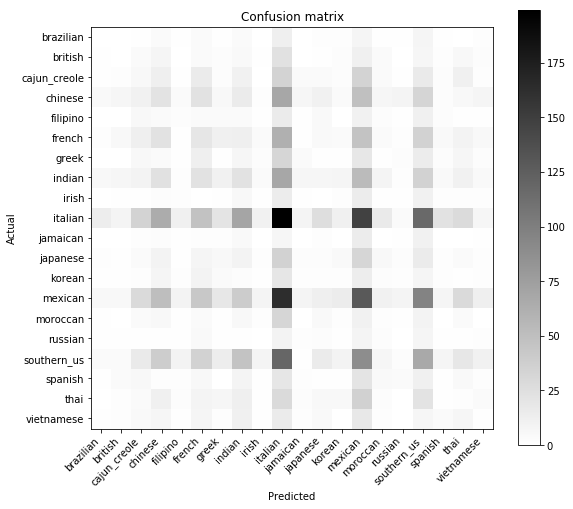

In [317]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, ovr_final_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, ovr_final_preds))
print('\n')
ConfusionMatrix(y_test, ovr_final_preds).plot();

It seems that our OvO SVM performs marginally better on the test set than our OvR model. Both precision and recall were slightly inferior in the OvR approach.

### Naive Bayes

The next model we are going to apply is Multinomial Naive Bayes. This model is particularly good at predicting categories from text and handling vectorized (sparse) data, so we have high hopes! 

Given that Naive Bayesian model is based on probabilities, it makes more sense to feed a count vector, rather than a tf-df vector. We will therefore apply the CountVectorizer() function to our original data, rather than using the train data we have been using so far.

In [336]:
from sklearn.feature_extraction.text import CountVectorizer

In [337]:
count_vect = CountVectorizer()

In [338]:
X_countvect = count_vect.fit_transform(features_processed)

In [339]:
X_countvect.shape

(39752, 2996)

In [340]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_countvect, y, test_size=0.33, random_state=42)

As a reminder, let's check out our prior probabilities for the cuisines: 

In [401]:
y.value_counts(normalize=True)

italian         0.197147
mexican         0.161904
southern_us     0.108649
indian          0.075392
chinese         0.067242
french          0.066512
cajun_creole    0.038891
thai            0.038640
japanese        0.035721
greek           0.029533
spanish         0.024829
korean          0.020879
vietnamese      0.020729
moroccan        0.020653
british         0.020225
filipino        0.018993
irish           0.016779
jamaican        0.013232
russian         0.012301
brazilian       0.011748
Name: cuisine, dtype: float64

In [346]:
# import algorithm

from sklearn.naive_bayes import MultinomialNB
mn = MultinomialNB()

In [347]:
# train model

mn.fit(X_train2, y_train2)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 91143.55 seconds ---


In [348]:
# apply model to test set and get predictions

mn_preds = mn.predict(X_test2)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.56      0.34      0.43       163
     british       0.32      0.38      0.35       259
cajun_creole       0.60      0.74      0.66       509
     chinese       0.72      0.89      0.80       866
    filipino       0.74      0.40      0.52       248
      french       0.51      0.52      0.51       859
       greek       0.66      0.66      0.66       384
      indian       0.83      0.87      0.85       940
       irish       0.67      0.39      0.49       217
     italian       0.82      0.79      0.81      2637
    jamaican       0.79      0.55      0.65       171
    japanese       0.88      0.59      0.71       462
      korean       0.77      0.66      0.71       247
     mexican       0.90      0.88      0.89      2124
    moroccan       0.72      0.75      0.73       292
     russian       0.63      0.25      0.36       168
 southern_us       0.60      0.75      0.67      1480

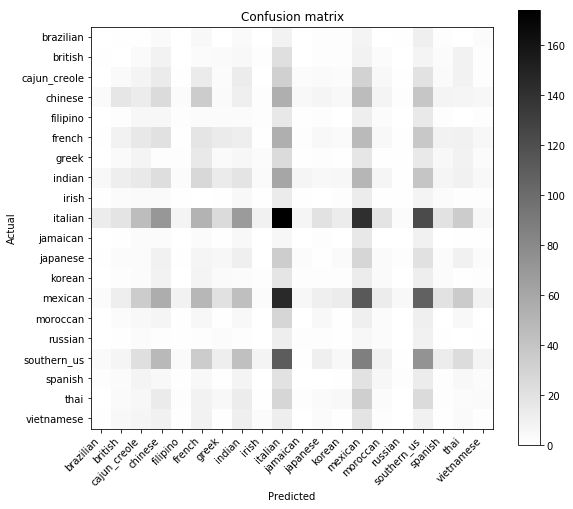

In [349]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, mn_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, mn_preds))
print('\n')
ConfusionMatrix(y_test, mn_preds).plot();

This prediction is average. We can see that, once again, some cuisines perform poorly on both precision and recall.  Let's try to further improve this by applying a grid search and tuning the hyperparameters.

#### Multinomical Naive Bayes with Grid Search

Let's try to further improve our MN model by tuning the parameters and applying a grid search.

The parameters  that we are most interesting in tuning are:

**alpha:** In this model, alpha refers to the pseudocount that we add to probabilities of bigrams to ensure everything is not zero. The only way for us to really find out the best alpha to set is by iterating over a range of options. 

**fit_prior:** This tells our model whether to learn class probabilities or not.

**class_prior:** This tells the model the class_priors to use if fit_prior is True. We set these based on the distribution of cuisines in our original dataset. These prior probabilities were listed at the beginning of the Naive Bayes section. 

In [352]:
# Specifying the parameters we want to test

alpha = [0.0001, 0.001, 0.01, 0.1, 1]
fit_prior = [True, False]
class_prior = [None, [0.011741,
                      0.020214,
                      0.038870,
                      0.067205,
                      0.018982,
                      0.066526,
                      0.029542,
                      0.075502,
                      0.016770,
                      0.197063,
                      0.013225,
                      0.035777,
                      0.020868,
                      0.161865,
                      0.020642,
                      0.012294,
                      0.108614,
                      0.024865,
                      0.038694,
                      0.020742]]

In [353]:
# Building our parameter grid

mn_param_grid = {'alpha': alpha,
               'fit_prior': fit_prior,
               'class_prior': class_prior}

In [354]:
# Running the Grid Search, prioritising accuracy

mn_grid_search = GridSearchCV(MultinomialNB(), param_grid = mn_param_grid, scoring="accuracy")

In [355]:
# fit the different combinatiojns

mn2 = mn_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 91282.99 seconds ---


In [356]:
# learn the best hyperparameters

print(mn2.best_score_)
print(mn2.best_params_)

0.7235760147185822
{'alpha': 0.01, 'class_prior': None, 'fit_prior': True}


Our best Multinomial NB model is one with an alpha of 0.01, that is fit prior based on what the model learns from the dataset (and not what we tell it in class prior).

In [361]:
# specify the best model

mn_best = MultinomialNB(alpha= 0.01, class_prior = None, fit_prior = True)

In [362]:
mn_best.fit(X_train,y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 91454.03 seconds ---


In [363]:
mn_best_preds = mn_best.predict(X_test2)

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

   brazilian       0.56      0.34      0.43       163
     british       0.32      0.38      0.35       259
cajun_creole       0.60      0.74      0.66       509
     chinese       0.72      0.89      0.80       866
    filipino       0.74      0.40      0.52       248
      french       0.51      0.52      0.51       859
       greek       0.66      0.66      0.66       384
      indian       0.83      0.87      0.85       940
       irish       0.67      0.39      0.49       217
     italian       0.82      0.79      0.81      2637
    jamaican       0.79      0.55      0.65       171
    japanese       0.88      0.59      0.71       462
      korean       0.77      0.66      0.71       247
     mexican       0.90      0.88      0.89      2124
    moroccan       0.72      0.75      0.73       292
     russian       0.63      0.25      0.36       168
 southern_us       0.60      0.75      0.67      1480

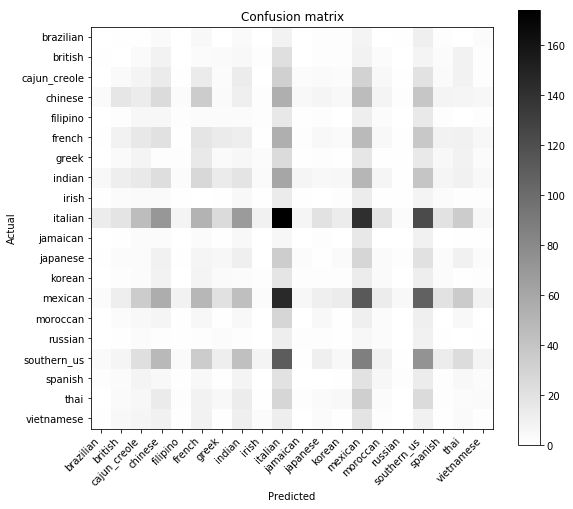

In [364]:
# cross validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, mn_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, mn_preds))
print('\n')
ConfusionMatrix(y_test, mn_preds).plot();

We can see that this is no different from the original MN model. It seems that this was not as promising a model as we had hoped.

# Summarising the models

Here I propose creating some kind of visualization of accuracy vs. time taken for out attempted models. Then we can write a quick summary about learnings, blah blah.

In [376]:
model = ['log_default', 'log_best', 
         'rfc_default', 'rfc_best', 
         'svc_default', 'svc_best', 'svc_ovr',
         'mn_default', 'mn_best']

accuracy = [0.7748303986584343, 0.7841298879487766,
            0.691821022943822, 0.7635490509947405,
            0.20100617425108622, 0.786873999542648, 0.7849683664913484, 
            0.7272657976979953, 0.7272657976979953]

print(len(model))
print(len(accuracy))

9
9


float

In [369]:
model_summary = pd.DataFrame(np.column_stack([model, accuracy]), 
                               columns=['Model', 'Accuracy'])

In [388]:
model_summary['Accuracy'] = model_summary['Accuracy'].astype(float)

In [392]:
model_summary = model_summary.sort_values(['Accuracy'], ascending = False).reset_index(drop=True)

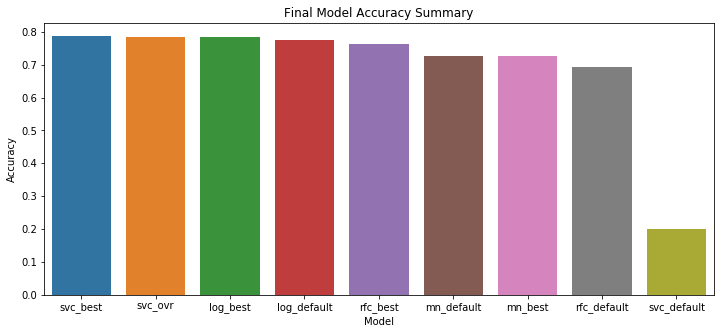

In [396]:
plt.figure(figsize = (12,5))
sns.barplot(x = 'Model', y ='Accuracy', data = model_summary)
plt.title('Final Model Accuracy Summary');

Our best model is the SVC with a linear kernel and a C of 1. Overall, the SVC and Logistic Regression models performed best. Random Forest and Naive Bayes were ok, but had more issues.

# Appendix: code for dimensionality reduction and balancing

### Dimensionality reduction with Truncated SVD

With our vectorized data, we now have a dataframe with 39752 rows, and 2996 words. This is a very large dataset for our models to train on, and it will be very difficult to run grid searches and pursue our curioisities with this size of a dataset.  We will therefore apply some dimensionaility reduction.  

PCA is the dimensionality reduction technique that we are most familiar with, but it unfortunately does not work with sparse matrices. We will instead apply Truncated SVC. According to scikit learn: 
* this transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.
* In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [269]:
# from sklearn.decomposition import TruncatedSVD

In [270]:
# tsvd = TruncatedSVD(n_components = 1000)

In [271]:
# X_transformed = tsvd.fit_transform(X_tfidf)

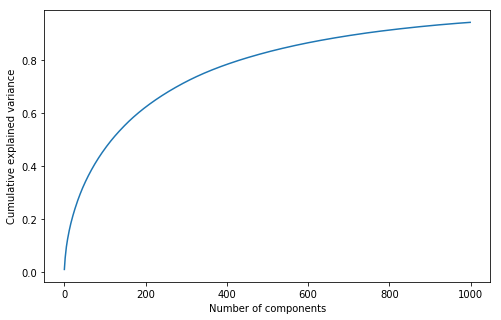

In [272]:
# plt.figure(figsize=(8,5))
# plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance');

It seems that 1000 components is enough. We could even reduce it to 800, but let's just leave it as 1000 for now.

### Balancing our data

As we learned during the EDA, the sample data is unbalanced. We have a high percentage of Italian recipes relative to all other cuisines. If we leave the data as is, the models that we train will learn that there is a higher probability of a recipe being Italian, and so its predictions will be biased. These models will likely have very low recall for non-Italian recipes.

##### Note: We originally used SMOTE, but it made our dataset too large to manage and created noise. We will instead use undersampling.

_To fix this, we will apply SMOTE, an over-sampling method. It creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records._
_Random Forests and SVMs are particularly sensitive to unbalanced data, so it is important that we apply the SMOTE methodology. It will also benefit the Logistic Regression and Naive Bayesian modelling._

In [292]:
# from imblearn.over_sampling import SMOTE
# import scipy

In [293]:
# counts per class before SMOTE
# scipy.stats.itemfreq(y_train)

In [294]:
# smt = SMOTE()
# X_train, y_train = smt.fit_sample(X_train, y_train)

In [295]:
# counts per class after SMOTE
# scipy.stats.itemfreq(y_train)

#### Undersampling using Cluster Centroids

To avoid losing potentially useful data, we will use the Cluster Centroids technique for undersampling. This method undersamples the majority class by replacing a cluster of majority samples This method finds the clusters of majority class with K-mean algorithms. Then it keeps the cluster centroids of the N clusters as the new majority samples.

In [296]:
#from imblearn.under_sampling import ClusterCentroids
#import scipy

In [297]:
# sampler = ClusterCentroids()
# X_train, y_train = sampler.fit_sample(X_train, y_train)

In [298]:
# scipy.stats.itemfreq(y_train)

array([['brazilian', 304],
       ['british', 545],
       ['cajun_creole', 1037],
       ['chinese', 1807],
       ['filipino', 507],
       ['french', 1785],
       ['greek', 790],
       ['indian', 2057],
       ['irish', 450],
       ['italian', 5200],
       ['jamaican', 355],
       ['japanese', 958],
       ['korean', 583],
       ['mexican', 4312],
       ['moroccan', 529],
       ['russian', 321],
       ['southern_us', 2839],
       ['spanish', 670],
       ['thai', 1030],
       ['vietnamese', 554]], dtype=object)

Now we have a balanced sample with which to train our models. 